# Entrenamiento de un Agente PPO con VizDoom

En este notebook, implementaremos un agente de Reinforcement Learning usando el algoritmo Proximal Policy Optimization (PPO) para jugar al juego de VizDoom.
Trabajo realizado por:
* Damián Pramparo
* Federico Domínguez Gómez

## Importación de bibliotecas
Usaremos las siguientes bibliotecas:
* **vizdoom**: Librería para interactuar con el entorno de VizDoom.
* **pandas**: Usada para crear un DataFrame y guardar datos en un archivo CSV.
* **torch**: Biblioteca para el aprendizaje profundo con PyTorch.
* **numpy**: Usada para manipular matrices numéricas.
* **Pool**: Para poder entrenas varios agentes al mismo tiempo

In [70]:
import vizdoom
import pandas as pd
import torch
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt

# Definición de la clase PPOAgent
Creamos una clase **PPOAgent** que representa nuestro agente PPO. Esta clase se encarga de definir la arquitectura de la política y de implementar los métodos necesarios para el entrenamiento.

In [42]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.001, alpha=0.99, epsilon=0.1):
        self.policy_net = torch.nn.Sequential(
            torch.nn.Linear(state_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, action_dim),
        )

        self.optimizer = torch.optim.RMSprop(self.policy_net.parameters(), lr=learning_rate, alpha=alpha, eps=epsilon)
        self.total_reward = 0
    def policy(self, state):
        logits = self.policy_net(state)

        logits = torch.squeeze(logits)

        action_probs = torch.softmax(logits, dim=0)
        action = torch.multinomial(action_probs, 1).item()

        return action

    def learn(self, experiences):
        loss = self.ppo_loss(experiences)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def ppo_loss(self, experiences):
        log_probs = [experience['log_probs'] for experience in experiences]
        advantages = [experience['advantage'] for experience in experiences]
        
        log_probs_tensor = torch.tensor(log_probs, requires_grad=True)
        advantages_tensor = torch.tensor(advantages, requires_grad=True)    

        ## Agrego una dimension adicional sino da error 
        log_probs_tensor = log_probs_tensor.unsqueeze(1)  
        advantages_tensor = advantages_tensor.unsqueeze(1) 

        policy_loss = -torch.mean(torch.sum(log_probs_tensor * advantages_tensor, dim=1))

        return policy_loss
    
    def update_total_reward(self, reward):
        self.total_reward += reward

In [43]:
sample_actions = [
    [1, 0, 0, 0, 0, 0, 0],  # MOVE_LEFT
    [0, 1, 0, 0, 0, 0, 0],  # MOVE_RIGHT
    [0, 0, 1, 0, 0, 0, 0],  # ATTACK
    [0, 0, 0, 1, 0, 0, 0],  # MOVE_FORWARD
    [0, 0, 0, 0, 1, 0, 0],  # MOVE_BACKWARD
    [0, 0, 0, 0, 0, 1, 0],  # TURN_LEFT
    [0, 0, 0, 0, 0, 0, 1],  # TURN_RIGHT
]

In [65]:
def train_agent(agent_id, learning_rate, alpha, epsilon, sample_actions):
    state_dim = 4
    action_dim = 7
    num_episodes = 3
    
    agent = PPOAgent(state_dim, action_dim, learning_rate, alpha, epsilon)
    
    game = vizdoom.DoomGame()
    game.load_config("deadly_corridor.cfg")
    game.set_doom_scenario_path("deadly_corridor.wad")
    game.init()
    
    for episode in range(num_episodes):
        total_reward = 0
        game.new_episode()

        state = torch.from_numpy(np.zeros((4,))).float() 

        experiences = []
        while not game.is_episode_finished():
            action = agent.policy(state)

            game.make_action(sample_actions[action])

            next_state = torch.from_numpy(np.zeros((4,))).float()
            reward = game.get_last_reward()
    
            advantage = reward 

            log_prob = torch.log(agent.policy_net(state)[action])

            experiences.append({
                'state': state,
                'action': action,
                'reward': reward,
                'next_state': next_state,
                'advantage': advantage,
                'log_probs': log_prob
            })
        
            state = next_state
            total_reward += reward
            
        agent.update_total_reward(total_reward)
        agent.learn(experiences)
        df = pd.DataFrame(experiences)
        df.to_csv('datos.csv')
        print('Episode {}: {}'.format(episode, game.get_total_reward()))

    game.close()
    return agent

In [45]:
def plot_rewards(rl_values, rewards):
    """
    Genera una gráfica de recompensas en función de los valores de RL.

    :param rl_values: Lista de valores de resistencia RL.
    :param rewards: Lista de recompensas correspondientes.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(rl_values, rewards, marker='o', linestyle='-', color='b')
    plt.title('Recompensas vs. Valores de RL')
    plt.xlabel('Valor de RL')
    plt.ylabel('Recompensas')
    plt.grid(True)
    plt.show()

In [ ]:
#no funciona, y no tengo idea por qué ni como hacer que ande
# Definimos una función para evaluar a un agente en el entorno
def evaluate_agent(agent, game, sample_actions, num_evaluation_episodes):
    total_rewards = []
    
    for episode in range(num_evaluation_episodes):
        game.new_episode()
        state = torch.from_numpy(np.zeros((4,))).float()
        episode_reward = 0
        
        while not game.is_episode_finished():
            action = agent.policy(state)
            game.make_action(sample_actions[action])
            next_state = torch.from_numpy(np.zeros((4,))).float()
            episode_reward += game.get_last_reward()
            state = next_state
        
        total_rewards.append(episode_reward)
    
    average_reward = np.mean(total_rewards)
    return average_reward

best_agent_id = None
best_average_reward = float("-inf")

evaluation_results = {}

for agent_id, learning_rate, alpha, epsilon in hyperparameter_combinations:
    print(f"Evaluando Agente {agent_id} con hiperparámetros: lr={learning_rate}, alpha={alpha}, epsilon={epsilon}")
    
    trained_agent = train_agent(agent_id, learning_rate, alpha, epsilon, sample_actions)
    
    average_reward = evaluate_agent(trained_agent, game, sample_actions, num_evaluation_episodes)
print(evaluation_results)

Episode 0: -113.25408935546875
Episode 1: -105.07649230957031
Episode 2: -91.02009582519531
Episode 0: -115.78916931152344
Episode 1: -110.07571411132812
Episode 2: -107.77993774414062
Episode 0: -114.83499145507812
Episode 1: -105.83685302734375
Episode 2: -114.74467468261719
Episode 0: -98.33935546875
Episode 1: -67.43136596679688
Episode 2: -104.58387756347656


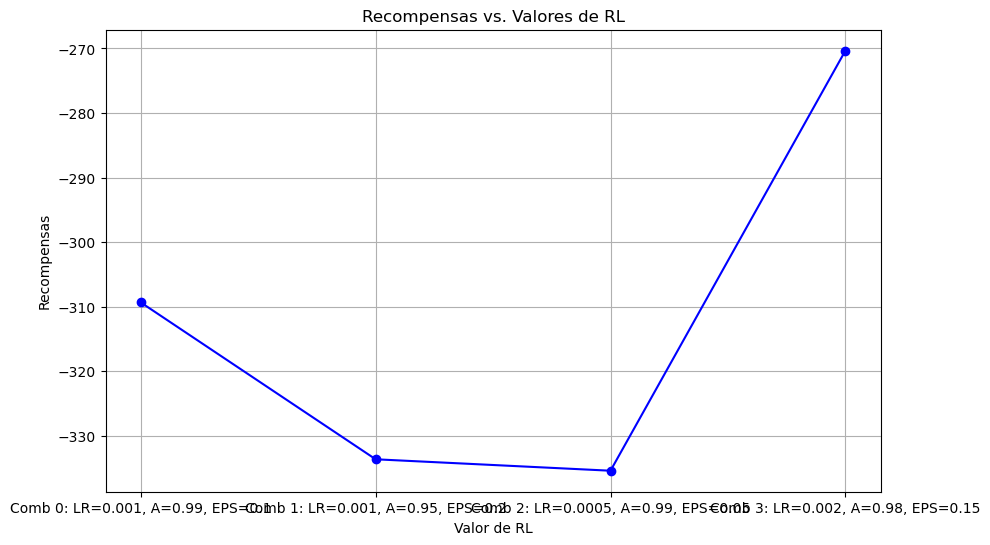

In [78]:
hyperparameter_combinations = [
    (0, 0.001, 0.99, 0.1),
    (1, 0.001, 0.95, 0.2),
    (2, 0.0005, 0.99, 0.05),
    (3, 0.002, 0.98, 0.15)
]

trained_agents = {}
rewards_by_hyperparameter = {} 

for agent_id, lr, a, eps in hyperparameter_combinations:
    agent = train_agent(agent_id, lr, a, eps, sample_actions)
    trained_agents[agent_id] = agent

# Recolectar recompensas para cada combinación de hiperparámetros
for agent_id, agent in trained_agents.items():
    rewards = agent.total_reward
    rewards_by_hyperparameter[agent_id] = rewards

rl_labels = [f"Comb {params[0]}: LR={params[1]}, A={params[2]}, EPS={params[3]}" for params in hyperparameter_combinations]
rewards = [rewards_by_hyperparameter[agent_id] for agent_id in rewards_by_hyperparameter]


plot_rewards(rl_labels, rewards)
